# Tutorial: Density Based Clustering

In this tutorial, we will review a typical pipeline to follow when analyzing the data. 
The task consists in obtaining an accurate description of the clusters present in the data and their hierarchies. 

1. Load the needed modules and plot functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dadapy import Data
from dadapy.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph

%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline


2. Import a test data set and plot it. We will employ two dimensional datasets from the original ADP paper (ref.) 

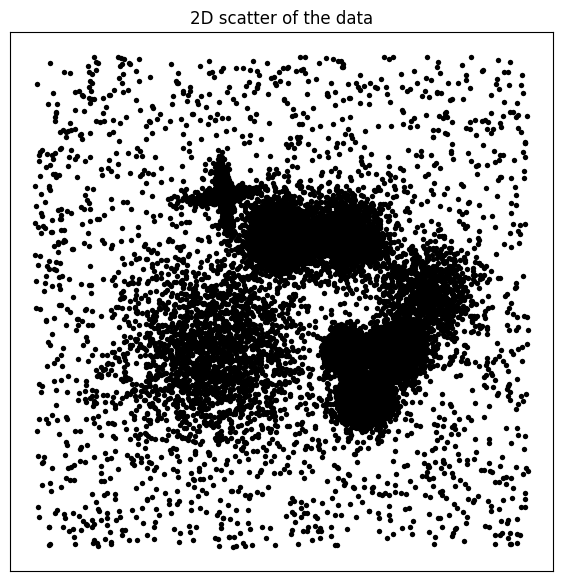

In [2]:
X = np.genfromtxt('datasets/Fig1.dat')
# X = np.genfromtxt('datasets/Fig2.dat')
# X = np.genfromtxt('datasets/FigS1.dat')
# X = np.genfromtxt('datasets/FigS2.dat')
# X = np.genfromtxt('datasets/FigS3.dat')
# X = np.genfromtxt('datasets/FigS4.dat')
f, ax = plt.subplots(1, 1, figsize = (7, 7),gridspec_kw={'hspace': 0.05, 'wspace': 0})
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_title('2D scatter of the data')
ax.scatter(X[:,0],X[:,1],s=15.,alpha=1.0,c='black',linewidths=0.0)
plt.show()

3. Initialize the Data class from the DADApy module. We set the verbose mode so we can follow all the steps.

In [3]:
data = Data(X,verbose=True)

4. Compute distances up to the maxk NN

In [4]:
data.compute_distances(maxk = 1000)

Computation of distances started
Computation of the distances up to 1000 NNs started
2.53 seconds for computing distances


5. Estimate the Intrinsic Dimension

In [5]:
data.compute_id_2NN()

ID estimation finished: selecting ID of [2.01]


(array([2.01]), 0.0, 0.08370783575996751)

6. Estimate the density

In [6]:
#data.compute_density_PAk()
data.compute_density_kstarNN()

kstar estimation started, Dthr = 23.92812698
0.55 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished


(array([-2.58, -7.12, -8.13, ..., -9.05, -8.76, -9.49]),
 array([0.08, 0.14, 0.12, ..., 0.16, 0.17, 0.1 ]))

#### Plot of the estimated densities

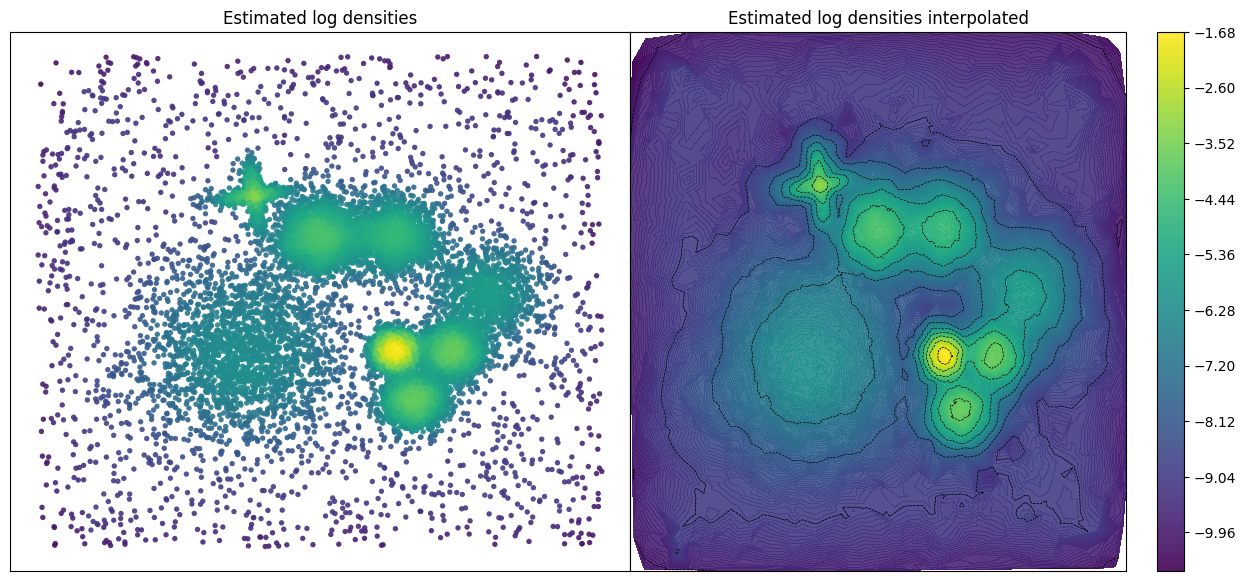

In [7]:
f, [ax1 ,ax2] = plt.subplots(1, 2, figsize = (16, 7),gridspec_kw={'hspace': 0.05, 'wspace': 0})
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.set_title('Estimated log densities')

ax1.scatter(X[:,0],X[:,1],s=15.,alpha=0.9, c = data.log_den,linewidths=0.0)
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.set_title('Estimated log densities interpolated')
ax2.tricontour(X[:,0],X[:,1],data.log_den,levels=10, linewidths=0.5, colors='k')
fig2=ax2.tricontourf(X[:,0],X[:,1],data.log_den,levels=250,alpha=0.9)

plt.colorbar(fig2)
plt.show()

Once the density is computed, DADApy offers two density based clustering methods:

    1.-Classical Density Peaks clustering.
    2.-Advanced Density Peaks clustering.

## Classical Density Peaks clustering

Following Rodriguez & Laio, Science 344 (6191), 1492-1496.

1.- Compute the so-called decison graph and plot it (Note that the density has been computed in previous steps).

Number of points for which self.delta needed call to cdist= 6


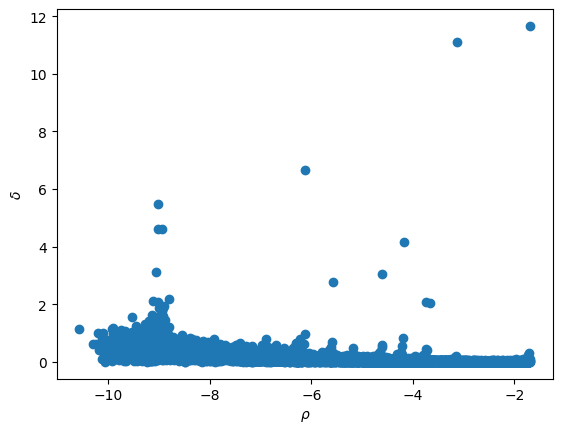

In [8]:
data.compute_DecGraph()
plot_DecGraph(data)

2.- Identify the centers of the clusters as outliers in the graph. We therefore define the characteristics that   the data points must fulfill to be considered as cluster centers (which are the parameters for the next step):

    a) the minimum log_den value (__dens_cut__).
    b) the minimum distance from a point with higher density (__delta_cut__) 

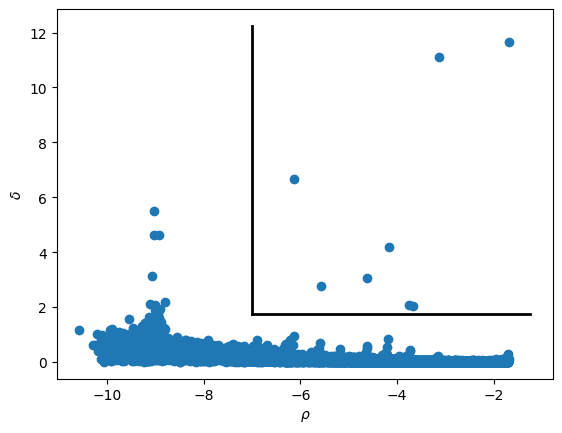

In [9]:
# This graph shows the chosen outliers
dens_cut=-7.
delta_cut=1.75
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\delta$")
plt.scatter(data.log_den, data.delta)
bottom,up=plt.ylim()
left,right=plt.xlim()
plt.plot ([dens_cut, dens_cut], [delta_cut, up], color="k", linestyle="-", linewidth=2)
plt.plot ([dens_cut, right], [delta_cut, delta_cut], color="k", linestyle="-", linewidth=2)
plt.show()


3.- Once the cluster centers are assigned, the next function perform the clustering assignation

In [10]:
data.compute_clustering_DP(dens_cut=dens_cut,delta_cut=delta_cut, halo=True)

array([ 0, -1, -1, ..., -1, -1, -1])

#### Plot of the DP clustering assignation

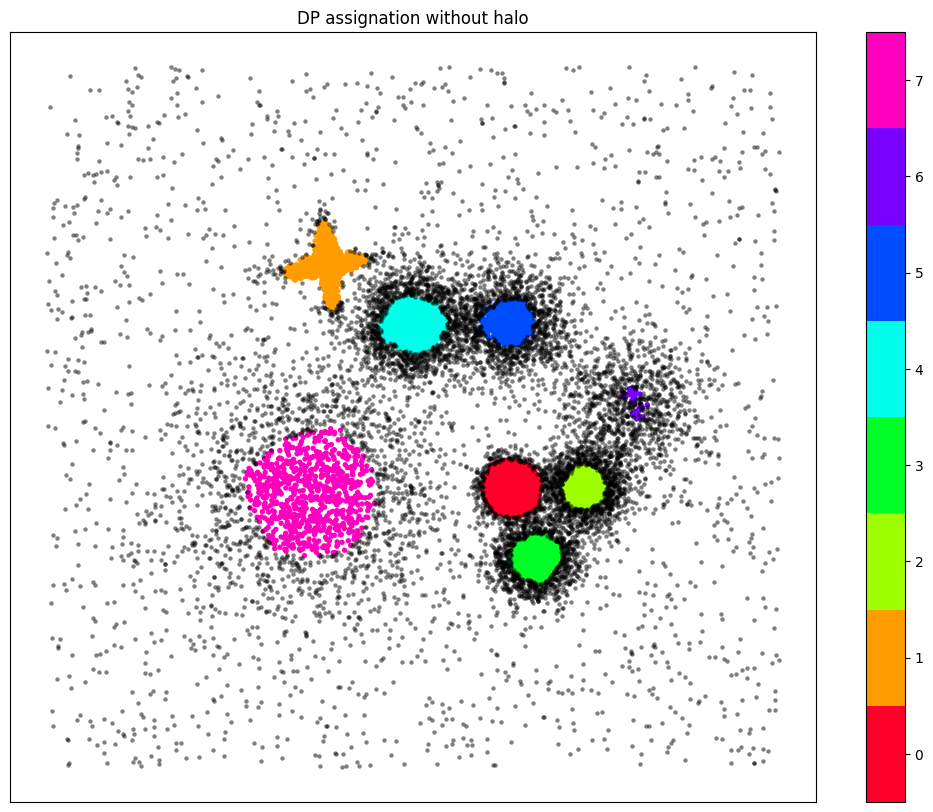

In [11]:
Nclus_m=np.max(data.cluster_assignment)+1
color= plt.get_cmap('gist_rainbow', Nclus_m)
f, ax = plt.subplots(1, 1, figsize = (13, 10))
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_title('DP assignation without halo')
xdtmp=[]
ydtmp=[]
ldtmp=[]
xntmp=[]
yntmp=[]
for j in range(len(data.cluster_assignment)):
    if (data.cluster_assignment[j]!=-1):
        xdtmp.append(data.X[j,0]) 
        ydtmp.append(data.X[j,1])
        ldtmp.append(data.cluster_assignment[j])
    else:
        xntmp.append(data.X[j,0])
        yntmp.append(data.X[j,1])
        
plt.scatter(xdtmp,ydtmp,s=15.,alpha=1.0, c=ldtmp,linewidths=0.0,cmap=color)
plt.colorbar(ticks=range(Nclus_m))
plt.clim(-0.5, Nclus_m-0.5)
plt.scatter(xntmp,yntmp,s=10.,alpha=0.5, c='black',linewidths=0.0)
plt.show()

## Advanced Density Peaks (ADP)

A more recent option (M d’Errico, E Facco, A Laio, A Rodriguez Information Sciences 560, 476-492) eliminates the
need of identifying the cluster centers in the decision graph. It has a single parameter, __Z__, that is a measure of the statistical realiability of the clusters found.  

In [12]:
data.compute_clustering_ADP(Z = 1.65, halo=True)

/home/francesco/anaconda3/envs/nope/lib/python3.11/site-packages/dadapy/dadac/bin/libdadac.so
You are running in a notebook maybe the timing output will break, but everything should be fine 
H1: Preliminary cluster assignment
	Finding putative centers: 0.001s
	Finding actual centers:   0.013s
	Tentative clustering:     0.002s
	Finalizing clustering:    0.000s

	Found 13 clusters
	Total time: 0.016s

H2: Finding border points
	Total time: 0.012s

Using dense implementation
H3: Merging clusters
	Finding merges:   0.000s
	Cluster merging:  0.000s
	Final operations: 0.001s

	Found 6 possible merges
	Surviving clusters 8
	Total time: 0.001s

Exporting results to python


array([4, 3, 1, ..., 2, 2, 1], dtype=int32)

#### Plot of the ADP clustering assignation

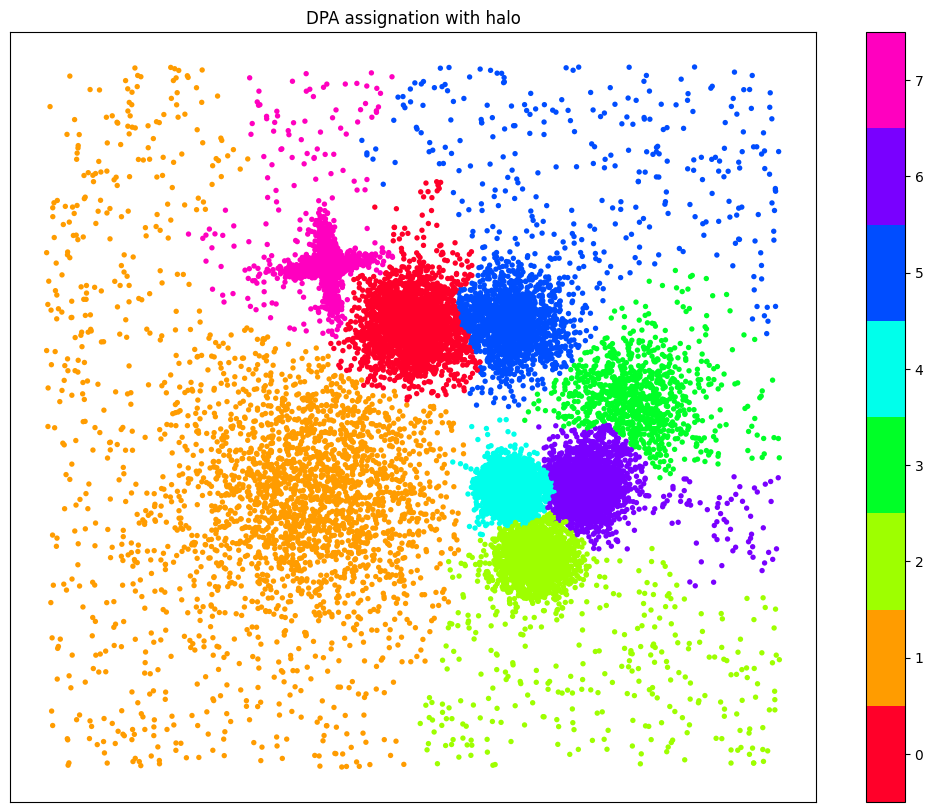

In [13]:
Nclus_m=len(data.cluster_centers) 
cmap = plt.get_cmap('gist_rainbow', Nclus_m)
f, ax = plt.subplots(1, 1, figsize = (13, 10))
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_title('DPA assignation with halo')
xdtmp=[]
ydtmp=[]
ldtmp=[]
xntmp=[]
yntmp=[]
for j in range(len(data.cluster_assignment)):
    if (data.cluster_assignment[j]!=-1):
        xdtmp.append(data.X[j,0]) 
        ydtmp.append(data.X[j,1])
        ldtmp.append(data.cluster_assignment[j])
    else:
        xntmp.append(data.X[j,0])
        yntmp.append(data.X[j,1])
        
plt.scatter(xdtmp,ydtmp,s=15.,alpha=1.0, c=ldtmp,linewidths=0.0,cmap=cmap)
plt.colorbar(ticks=range(Nclus_m))
plt.clim(-0.5, Nclus_m-0.5)
plt.scatter(xntmp,yntmp,s=10.,alpha=0.5, c='black',linewidths=0.0)
plt.show()

Moreover, the method provides a measure of the hierarchical relationships among clusters. Following the original paper, we have three ways for visualizing these relationships: 
As a *dendrogram*, as a *2D multidimensional scaling projection* and as a *matrix*.   

#### Dendrogram obtention and interpretation

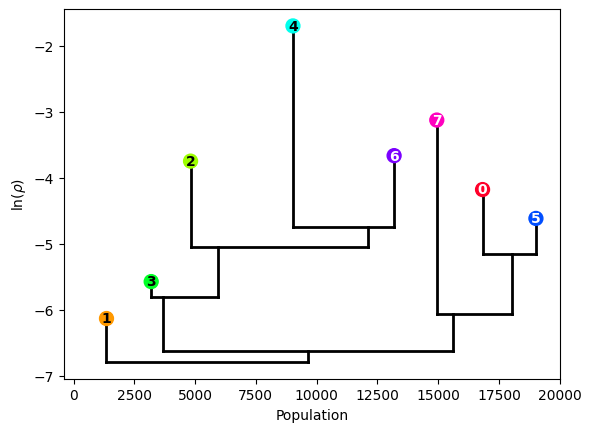

In [14]:
get_dendrogram(data,logscale=False,cmap="gist_rainbow")

The dendrogram is a classical way of visualizing hierarchies. The height of the points correspond to the log_den
value of the cluster center, and the value on the y-axis of the connections corresponds to the log_den at the 
border between clusters. To encode more information, the space around each point is proportional to the cluster
population (or its logarithm if the logscale variable is set to True).

#### 2D multidimensional scaling obtention and interpretation

/home/francesco/anaconda3/envs/nope/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


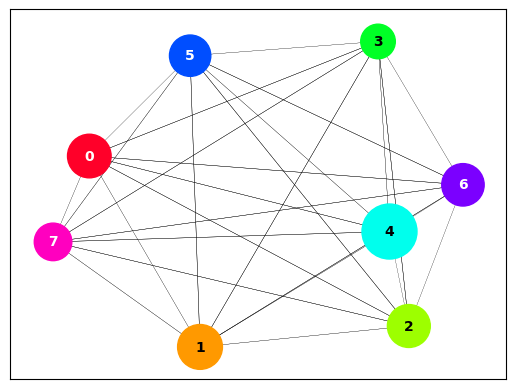

In [15]:
plot_MDS(data,cmap='gist_rainbow')

This projection allows to see the similarity relationships among clusters, based on the principle that the higher is the density of points at the border between clusters, the more similar they are. The size of the cluster circle is proportional to its population and the distances between circles and the widths of the lines connecting them are proportional to the density at the borders between clusters.  

#### Matrix obtention and interpretation

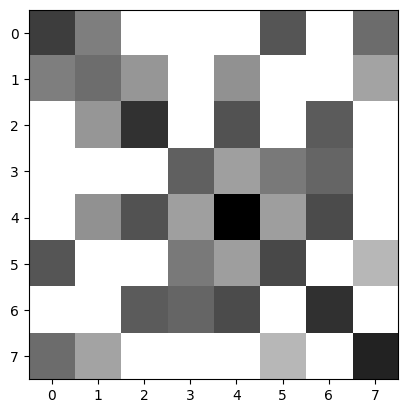

In [16]:
plot_matrix(data)

This is a direct visualization of the key densities resulting from the clustering. It is matrix plot in gray scale, where the darkest the square, the higher the density. The diagonal points correspond to the center of the cluster while the off-diagonal correspond to the density at the border.  